<a href="https://colab.research.google.com/github/VincentNFR/openclassrooms_p06/blob/ResNet50/resnet_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

# Import des donneés

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
raw_image_tensor = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/images_reduced.npy', allow_pickle=True)
raw_label_tensor = np.load('/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/data/label_reduced.npy', allow_pickle=True)

In [4]:
raw_image_tensor.shape, raw_label_tensor.shape

((1124,), (1124,))

# Preparation des sets

In [5]:
from numpy import expand_dims
import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from skimage.transform import resize
from tqdm.notebook import trange, tqdm

np.random.seed(1)

image_generator = ImageDataGenerator(
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    rotation_range = 20,
    width_shift_range = 0.2,
    height_shift_range = 0.2
    )

def generate_new_image(image, target_size=(224,224), seed=1):
    it = image_generator.flow(expand_dims(image, 0), batch_size=1, seed=seed).next()[0].astype('uint8')
    new_image = resize(it, target_size, anti_aliasing=True)
    return new_image

def normalize(x):
    return x/255.

def generate_dataframe(raw_label_tensor, raw_image_tensor, nb_images_per_class=100, target_size=(224,224)):
    """
    Genere une image à partir du jeu de données
    - Image aléatoire
    - Image resize
    - Image normalisee
    return df['Images','Labels'], Dict(Label: Breed)
    """
    label_unique = np.unique(raw_label_tensor)
    df = pd.DataFrame(columns=['Images', 'Labels'])
    convert_labels = dict()
    for i in trange(len(label_unique), desc='Total set'):
        breed = label_unique[i]
        convert_labels[i] = breed
        n_image_to_create = nb_images_per_class
        samples = np.where(raw_label_tensor==breed)[0]
        label_arr = np.zeros((len(label_unique)))
        label_arr[i] = 1
        for j in tqdm(range(n_image_to_create), desc=breed):
            sample_image = raw_image_tensor[np.random.choice(samples)]
            new_image = generate_new_image(sample_image)
            
            df = df.append(dict(zip(df.columns,[new_image, label_arr])), ignore_index=True)
    df['Images'].apply(normalize)
    return df, convert_labels

In [6]:
d, convert_labels = generate_dataframe(raw_label_tensor, raw_image_tensor, nb_images_per_class=500, target_size=(224,224))

Total set:   0%|          | 0/5 [00:00<?, ?it/s]

afghan_hound:   0%|          | 0/500 [00:00<?, ?it/s]

maltese_dog:   0%|          | 0/500 [00:00<?, ?it/s]

pomeranian:   0%|          | 0/500 [00:00<?, ?it/s]

samoyed:   0%|          | 0/500 [00:00<?, ?it/s]

scottish_deerhound:   0%|          | 0/500 [00:00<?, ?it/s]

In [7]:
from sklearn.model_selection import train_test_split

def split_dataframe(df, x_cols, y_cols, train_split=0.7, test_split=0.5, random_state=0):
    """
    Split du dataset en 3 parties avec mélange :
        - Train set
        - Validation set
        - Test set
    """
    X_train, X_tmp, y_train, y_tmp = train_test_split(df[x_cols], df[y_cols], test_size=1-train_split, random_state=random_state, shuffle=True)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=test_split, random_state=random_state)

    return np.array([im for im in X_train.values]), np.array([im for im in y_train.values]), np.array([im for im in X_val.values]), np.array([im for im in y_val.values]), np.array([im for im in X_test.values]), np.array([im for im in y_test.values])

In [8]:
X_train, y_train, X_val, y_val, X_test, y_test = split_dataframe(d, x_cols='Images', y_cols='Labels', train_split=0.7, test_split=0.5, random_state=0)

In [9]:
X_train.shape, X_val.shape, X_test.shape

((1749, 224, 224, 3), (375, 224, 224, 3), (376, 224, 224, 3))

# Import du modèle d'apprentissage

In [11]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout

resnet_load = tf.keras.applications.ResNet50(
    include_top=True,
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=5,
    classifier_activation="softmax",
)

model = resnet_load
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [12]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

In [13]:
epochs = 10
batch_size = 32
path = '/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/resnet_upgrade'
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path}/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    #callbacks=[checkpointer], 
    verbose=1
    )

Epoch 1/10
87/87 [==============================] - ETA: 0s - loss: 0.3546 - accuracy: 0.9260
Epoch 1: val_loss improved from inf to 71.91038, saving model to /content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/vgg_upgrade/weights.bestaugmented.from_scratch.hdf5
87/87 [==============================] - 97s 807ms/step - loss: 0.3546 - accuracy: 0.9260 - val_loss: 71.9104 - val_accuracy: 0.1947
Epoch 2/10
87/87 [==============================] - ETA: 0s - loss: 0.0882 - accuracy: 0.9719
Epoch 2: val_loss did not improve from 71.91038
87/87 [==============================] - 47s 545ms/step - loss: 0.0882 - accuracy: 0.9719 - val_loss: 166.0337 - val_accuracy: 0.2000
Epoch 3/10
87/87 [==============================] - ETA: 0s - loss: 0.0147 - accuracy: 0.9994
Epoch 3: val_loss improved from 71.91038 to 33.62403, saving model to /content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/vgg_upgrade/weights.bestaugmented.from_scratch.hdf5
87/87 [=====================

In [14]:
#model.load_weights(f'{path}/weights.bestaugmented.from_scratch.hdf5')

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
print(f'Test accuracy: {test_accuracy} %')

Test accuracy: 100.0 %


In [15]:
(eval_loss, eval_accuracy) = model.evaluate(X_test, y_test, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

19/19 [==============================] - 5s 208ms/step - loss: 1.2840e-07 - accuracy: 1.0000
Validation Loss:  1.2840361307553394e-07
Validation Accuracy:  1.0


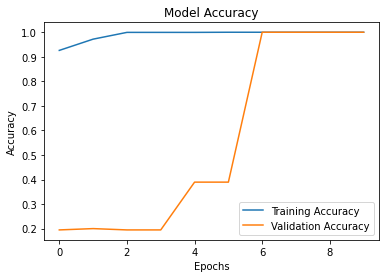

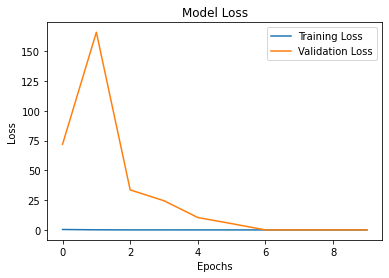

In [16]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()

# Amelioration

In [29]:
resnet_load = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))

# Ajout de layers
model = Sequential()
model.add(resnet_load)
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_3 (Flatten)         (None, 100352)            0         
                                                                 
 dense_9 (Dense)             (None, 1024)              102761472 
                                                                 
 dropout_6 (Dropout)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               262400    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 dense_11 (Dense)            (None, 5)               

In [32]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss= 'categorical_crossentropy',
    metrics= ['accuracy']
    )

epochs = 10
batch_size = 20
path = '/content/drive/MyDrive/Colab Notebooks/OpenClassRooms/6/saved_model/resnet_upgrade'
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath=f'{path}/weights.bestaugmented.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

history = model.fit(
    x=X_train, y=y_train,
    validation_data=(X_val, y_val), 
    steps_per_epoch=X_train.shape[0]//batch_size, 
    epochs=epochs, 
    #callbacks=[checkpointer], 
    verbose=1
    )

Epoch 1/10
87/87 [==============================] - 61s 614ms/step - loss: 1.4035 - accuracy: 0.9845 - val_loss: 1.8986 - val_accuracy: 0.2027
Epoch 2/10
87/87 [==============================] - 54s 617ms/step - loss: 1.3243 - accuracy: 0.9923 - val_loss: 52832.7578 - val_accuracy: 0.1947
Epoch 3/10
87/87 [==============================] - 51s 587ms/step - loss: 28.0298 - accuracy: 0.9305 - val_loss: 4843265.5000 - val_accuracy: 0.1947
Epoch 4/10
87/87 [==============================] - 51s 588ms/step - loss: 0.0052 - accuracy: 0.9989 - val_loss: 11102.8535 - val_accuracy: 0.1947
Epoch 5/10
87/87 [==============================] - 51s 584ms/step - loss: 15.1346 - accuracy: 0.9586 - val_loss: 227611.1562 - val_accuracy: 0.2027
Epoch 6/10
87/87 [==============================] - 51s 585ms/step - loss: 0.0016 - accuracy: 0.9994 - val_loss: 741.5489 - val_accuracy: 0.3973
Epoch 7/10
87/87 [==============================] - 51s 587ms/step - loss: 1.4871e-04 - accuracy: 1.0000 - val_loss: 3.

In [33]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in X_test]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(y_test, axis=1))/len(dog_breed_predictions)
print(f'Test accuracy: {test_accuracy} %')

Test accuracy: 56.38297872340426 %


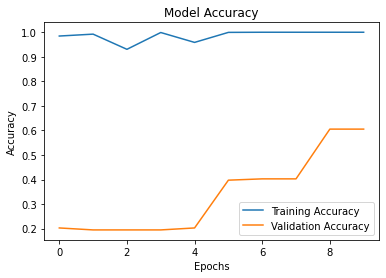

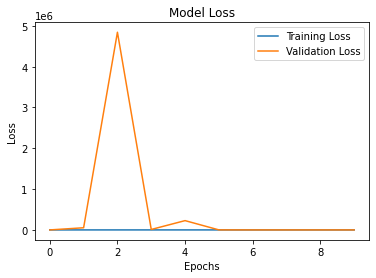

In [34]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.show()